In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io as sio
from xmitgcm import open_mdsdataset
import pandas as pd
import xarray as xr
from scipy import interpolate
from skimage import measure
from copy import deepcopy
import time
import seaborn

In [3]:
plt.rcParams.update({'font.size': 14, 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize': 14,
                     'legend.fontsize': 12, 'legend.handlelength': 2})

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

In [5]:
data = np.load('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/eddy_sla_over.npz')
eddy_sla1 = data['arr_0'][1:]
eddy_sla2 = data['arr_1'][1:]
eddy_slam = data['arr_2'][1:]

### Normalized SSHA
- $$SSHA_{norm} = \frac{dSSHA}{SSHA_{mean}}$$

In [6]:
sla_norm = (eddy_sla2 - eddy_sla1)/ eddy_slam

(-3, 3)

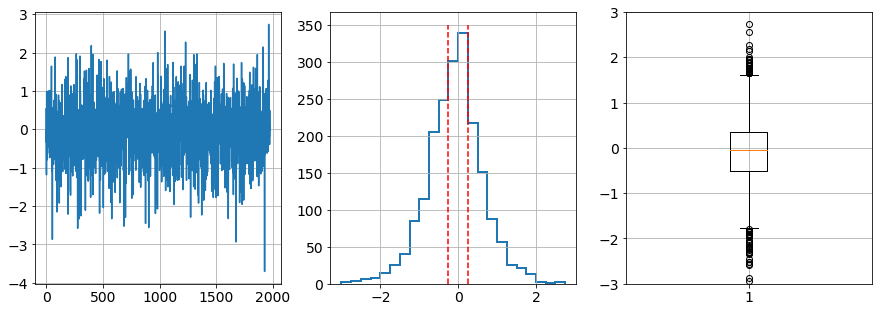

In [7]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(sla_norm)
plt.grid()

plt.subplot(132)
plt.hist(sla_norm, bins=np.arange(-3,3,0.25), histtype='step', linewidth=2)
plt.grid()
plt.plot([-0.25, -0.25], [0, 350], 'r--')
plt.plot([0.25, 0.25], [0, 350], 'r--')

plt.subplot(133)
plt.boxplot(sla_norm)
plt.grid()
plt.ylim(-3, 3)

- Growing eddy, SSHA_norm >= 0.25: 578/1973 = 29.3%
- Stable eddy, -0.25 < SSHA_norm < 0.25: 640/1973 = 32.4%
- Decaying eddy, SSH_norm < -0.25: 755/1973 = 38.3% 

In [9]:
id1 = np.where(sla_norm >= 0.25)
id2 = np.where(sla_norm <= -0.25)
id3 = np.where((sla_norm > -0.25) & (sla_norm < 0.25))
#print(flux1_new.shape[0])
print(len(id1[0]))
print(len(id2[0]))
print(len(id3[0]))

578
755
640


### 3 groups

#### 30-day eddy

926
1036


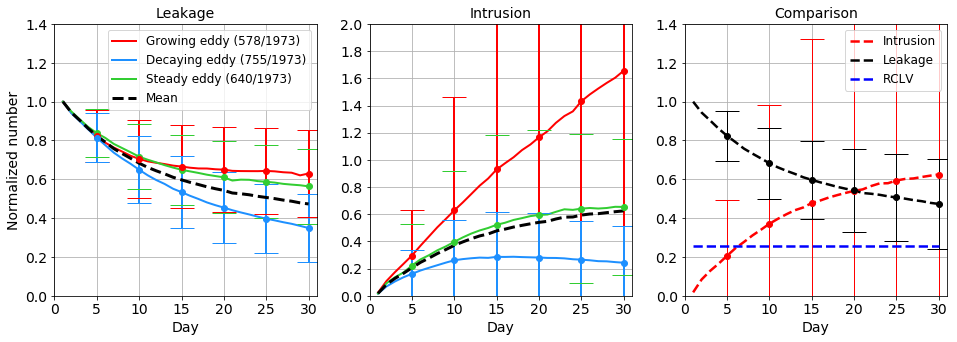

In [11]:
flux1 = np.load('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/flux1.npy')[1:, :]
flux2 = np.load('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/flux2.npy')[1:, :]

flux1_new = deepcopy(flux1)
flux2_new = deepcopy(flux2)

id1 = np.where(sla_norm >= 0.25)
id2 = np.where(sla_norm <= -0.25)
id3 = np.where((sla_norm > -0.25) & (sla_norm < 0.25))

for i in np.arange(flux1_new.shape[0]):

    if flux1[i, 3] == 0:
        flux1_new[i, 3:] = np.nan
    else:
        flux1_new[i, 3:] = flux1_new[i, 3:] / flux1[i, 3]
        flux2_new[i, 3:] = flux2_new[i, 3:] / flux1[i, 3]

# check flux2_new
for i in np.arange(flux1_new.shape[0]):
    if flux2_new[i, 5] > 10:
        print(i)
        flux2_new[i, :] = np.nan

flux1_grow = flux1_new[id1, 3:][0]
flux1_decay = flux1_new[id2, 3:][0]
flux1_stable = flux1_new[id3, 3:][0]
flux2_grow = flux2_new[id1, 3:][0]
flux2_decay = flux2_new[id2, 3:][0]
flux2_stable = flux2_new[id3, 3:][0]

flux1_grow_mean = np.nanmean(
    flux1[id1, 3:][0], 0) / np.nanmean(flux1[id1, 3][0])
flux1_decay_mean = np.nanmean(
    flux1[id2, 3:][0], 0) / np.nanmean(flux1[id2, 3][0])
flux1_stable_mean = np.nanmean(
    flux1[id3, 3:][0], 0) / np.nanmean(flux1[id3, 3][0])
flux1_mean = np.nanmean(flux1[:, 3:], 0) / np.nanmean(flux1[:, 3], 0)

flux2_grow_mean = np.nanmean(
    flux2[id1, 3:][0], 0) / np.nanmean(flux1[id1, 3][0])
flux2_decay_mean = np.nanmean(
    flux2[id2, 3:][0], 0) / np.nanmean(flux1[id2, 3][0])
flux2_stable_mean = np.nanmean(
    flux2[id3, 3:][0], 0) / np.nanmean(flux1[id3, 3][0])

flux2_mean = np.nanmean(flux2[:, 3:], 0) / np.nanmean(flux1[:, 3], 0)

rclv_num = flux1_new[:, 1]
rclv_num = np.nanmean(rclv_num)
eddy_anum = np.nanmean(flux1[1:, 3])

tt = np.arange(30) + 1
flux1_grow_err = np.zeros((3, 6))
flux1_decay_err = np.zeros((3, 6))
flux1_stable_err = np.zeros((3, 6))

# -----------------------------
dnum = 0
for day in np.arange(5, 31, 5):
    flux1_grow_err[0, dnum] = tt[day-1]
    flux1_grow_err[1, dnum] = flux1_grow_mean[day-1]
    flux1_grow_err[2, dnum] = np.nanstd(flux1_grow[:, day-1])
    flux1_decay_err[0, dnum] = tt[day-1]
    flux1_decay_err[1, dnum] = flux1_decay_mean[day-1]
    flux1_decay_err[2, dnum] = np.nanstd(flux1_decay[:, day-1])
    flux1_stable_err[0, dnum] = tt[day-1]
    flux1_stable_err[1, dnum] = flux1_stable_mean[day-1]
    flux1_stable_err[2, dnum] = np.nanstd(flux1_stable[:, day-1])
    dnum = dnum + 1

flux2_grow_err = np.zeros((3, 6))
flux2_decay_err = np.zeros((3, 6))
flux2_stable_err = np.zeros((3, 6))

dnum = 0
for day in np.arange(5, 31, 5):
    flux2_grow_err[0, dnum] = tt[day-1]
    flux2_grow_err[1, dnum] = flux2_grow_mean[day-1]
    flux2_grow_err[2, dnum] = np.nanstd(flux2_grow[:, day-1])
    flux2_decay_err[0, dnum] = tt[day-1]
    flux2_decay_err[1, dnum] = flux2_decay_mean[day-1]
    flux2_decay_err[2, dnum] = np.nanstd(flux2_decay[:, day-1])
    flux2_stable_err[0, dnum] = tt[day-1]
    flux2_stable_err[1, dnum] = flux2_stable_mean[day-1]
    flux2_stable_err[2, dnum] = np.nanstd(flux2_stable[:, day-1])
    dnum = dnum + 1

flux1_mean_err = np.zeros((3, 6))
flux2_mean_err = np.zeros((3, 6))

dnum = 0
for day in np.arange(5, 31, 5):
    flux1_mean_err[0, dnum] = tt[day-1]
    flux1_mean_err[1, dnum] = flux1_mean[day-1]
    flux1_mean_err[2, dnum] = np.nanstd(flux1_new[:, day+2])
    flux2_mean_err[0, dnum] = tt[day-1]
    flux2_mean_err[1, dnum] = flux2_mean[day-1]
    flux2_mean_err[2, dnum] = np.nanstd(flux2_new[:, day+2])

    dnum = dnum + 1

fig = plt.figure(figsize=(16, 5))

plt.subplot(131)

hl1 = plt.plot(tt, flux1_grow_mean.T, 'red', linewidth=2, label='Growing eddy (578/1973)')
hl2 = plt.plot(tt, flux1_decay_mean.T, 'dodgerblue',
               linewidth=2, label='Decaying eddy (755/1973)')
hl3 = plt.plot(tt, flux1_stable_mean.T, 'limegreen',
               linewidth=2, label='Steady eddy (640/1973)')
hl4 = plt.plot(tt, flux1_mean, 'k--', linewidth=3, label='Mean')

plt.errorbar(flux1_stable_err[0, :], flux1_stable_err[1, :],
             flux1_stable_err[2, :], fmt='o', color='limegreen', linewidth=2, capsize=12)

plt.errorbar(flux1_grow_err[0, :], flux1_grow_err[1, :],
             yerr=flux1_grow_err[2, :], fmt='o', color='red', linewidth=2, capsize=12)

plt.errorbar(flux1_decay_err[0, :], flux1_decay_err[1, :],
             flux1_decay_err[2, :], fmt='o', color='dodgerblue', linewidth=2, capsize=12)


plt.legend(loc=1)
#hl4 = plt.plot([1, 30], [rclv_num/eddy_anum, rclv_num/eddy_anum], 'lime', linewidth=2, linestyle='--')
plt.grid()
plt.xticks(ticks=np.arange(0, 31, 5))
plt.xlim(0, 31)
plt.ylim(0, 1.4)
plt.xlabel('Day')
plt.ylabel('Normalized number')
plt.title('Leakage')

plt.subplot(132)
plt.plot(tt, flux2_grow_mean.T, 'red', linewidth=2)
plt.plot(tt, flux2_decay_mean.T, 'dodgerblue', linewidth=2)
plt.plot(tt, flux2_stable_mean.T, 'limegreen', linewidth=2)

hl4 = plt.plot(tt, flux2_mean, 'k--', linewidth=3, label='Mean')

plt.errorbar(flux2_stable_err[0, :], flux2_stable_err[1, :],
             flux2_stable_err[2, :], fmt='o', color='limegreen', linewidth=2, capsize=12)

plt.errorbar(flux2_grow_err[0, :], flux2_grow_err[1, :],
             yerr=flux2_grow_err[2, :], fmt='o', color='red', linewidth=2, capsize=12)

plt.errorbar(flux2_decay_err[0, :], flux2_decay_err[1, :],
             flux2_decay_err[2, :], fmt='o', color='dodgerblue', linewidth=2, capsize=12)

plt.grid()
plt.xticks(ticks=np.arange(0, 31, 5))
plt.xlim(0, 31)
plt.yticks(ticks=np.arange(0, 2.1, 0.2))
plt.ylim(0, 2.0)
plt.yticks(ticks=np.arange(0, 2.1, 0.2))
plt.xlabel('Day')
plt.title('Intrusion')


plt.subplot(133)

hl2 = plt.plot(np.arange(1, 31, 1), flux2_mean,
               color='r', linestyle='--', linewidth=2.5, label='Intrusion')

hl1 = plt.plot(np.arange(1, 31, 1), flux1_mean,
               'k', linestyle='--', linewidth=2.5, label='Leakage')

hl3 = plt.plot([1, 30], [rclv_num/eddy_anum, rclv_num/eddy_anum],
               'blue', linewidth=2.5, linestyle='--', label='RCLV')

plt.errorbar(flux2_mean_err[0, :], flux2_mean_err[1, :],
             flux2_mean_err[2, :], fmt='o', color='r', linewidth=1, capsize=12)

plt.errorbar(flux1_mean_err[0, :], flux1_mean_err[1, :],
             yerr=flux1_mean_err[2, :], fmt='o', color='k', linewidth=1, capsize=12)

plt.legend(loc=1)
plt.grid()
plt.xticks(ticks=np.arange(0, 31, 5))
plt.xlim(0, 31)
plt.xlabel('Day')
plt.ylim(0, 1.4)
plt.title('Comparison')

plt.savefig('Figure_08.png', dpi=300, bbox_inches='tight')

In [12]:
print(flux1_new.shape[0])
print(len(id1[0]))
print(len(id2[0]))
print(len(id3[0]))

1973
578
755
640


- 90-day

In [13]:
data = np.load('/home/tls2913/scripts/RCLV/statistics_2d/rclv_90_0.1/eddy_sla_over_90.npz')
eddy_sla1 = data['arr_0'][1:]
eddy_sla2 = data['arr_1'][1:]
eddy_slam = data['arr_2'][1:]

sla_norm = (eddy_sla2 - eddy_sla1)/ eddy_slam

(-3, 3)

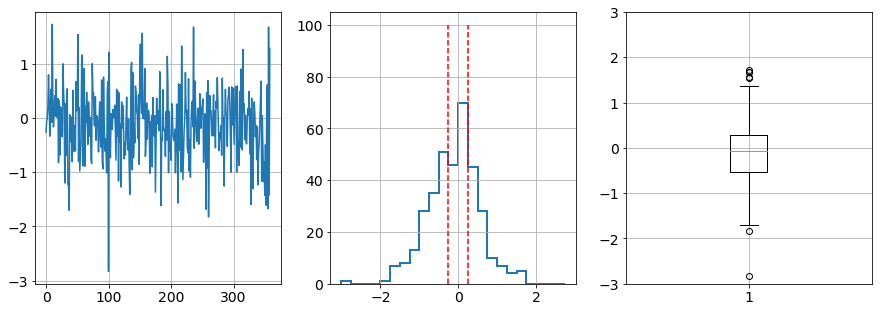

In [14]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(sla_norm)
plt.grid()

plt.subplot(132)
plt.hist(sla_norm, bins=np.arange(-3,3,0.25), histtype='step', linewidth=2)
plt.grid()
plt.plot([-0.25, -0.25], [0, 100], 'r--')
plt.plot([0.25, 0.25], [0, 100], 'r--')

plt.subplot(133)
plt.boxplot(sla_norm)
plt.grid()
plt.ylim(-3, 3)

In [15]:
flux1 = np.load(
    '/home/tls2913/scripts/RCLV/statistics_2d/rclv_90_0.1/flux1.npy')[1:, :]
flux2 = np.load(
    '/home/tls2913/scripts/RCLV/statistics_2d/rclv_90_0.1/flux2.npy')[1:, :]

flux1_new = deepcopy(flux1)
flux2_new = deepcopy(flux2)

id1 = np.where(sla_norm >= 0.25)
id2 = np.where(sla_norm <= -0.25)
id3 = np.where((sla_norm > -0.25) & (sla_norm < 0.25))

for i in np.arange(flux1_new.shape[0]):

    if flux1[i, 3] == 0:
        flux1_new[i, 3:] = np.nan
    else:
        flux1_new[i, 3:] = flux1_new[i, 3:] / flux1[i, 3]
        flux2_new[i, 3:] = flux2_new[i, 3:] / flux1[i, 3]

# check flux2_new
for i in np.arange(flux1_new.shape[0]):
    if flux2_new[i, 5] > 10:
        print(i)
        flux2_new[i, :] = np.nan

flux1_grow = flux1_new[id1, 3:][0]
flux1_decay = flux1_new[id2, 3:][0]
flux1_stable = flux1_new[id3, 3:][0]
flux2_grow = flux2_new[id1, 3:][0]
flux2_decay = flux2_new[id2, 3:][0]
flux2_stable = flux2_new[id3, 3:][0]

flux1_grow_mean = np.nanmean(
    flux1[id1, 3:][0], 0) / np.nanmean(flux1[id1, 3][0])
flux1_decay_mean = np.nanmean(
    flux1[id2, 3:][0], 0) / np.nanmean(flux1[id2, 3][0])
flux1_stable_mean = np.nanmean(
    flux1[id3, 3:][0], 0) / np.nanmean(flux1[id3, 3][0])
flux1_mean = np.nanmean(flux1[:, 3:], 0) / np.nanmean(flux1[:, 3], 0)

flux2_grow_mean = np.nanmean(
    flux2[id1, 3:][0], 0) / np.nanmean(flux1[id1, 3][0])
flux2_decay_mean = np.nanmean(
    flux2[id2, 3:][0], 0) / np.nanmean(flux1[id2, 3][0])
flux2_stable_mean = np.nanmean(
    flux2[id3, 3:][0], 0) / np.nanmean(flux1[id3, 3][0])

flux2_mean = np.nanmean(flux2[:, 3:], 0) / np.nanmean(flux1[:, 3], 0)

rclv_num = flux1_new[:, 1]
rclv_num = np.nanmean(rclv_num)
eddy_anum = np.nanmean(flux1[1:, 3])

190


In [16]:
tt = np.arange(90) + 1
flux1_grow_err = np.zeros((3, 9))
flux1_decay_err = np.zeros((3, 9))
flux1_stable_err = np.zeros((3, 9))

# -----------------------------
dnum = 0
for day in np.arange(10, 91, 10):
    flux1_grow_err[0, dnum] = tt[day-1]
    flux1_grow_err[1, dnum] = flux1_grow_mean[day-1]
    flux1_grow_err[2, dnum] = np.nanstd(flux1_grow[:, day-1])
    flux1_decay_err[0, dnum] = tt[day-1]
    flux1_decay_err[1, dnum] = flux1_decay_mean[day-1]
    flux1_decay_err[2, dnum] = np.nanstd(flux1_decay[:, day-1])
    flux1_stable_err[0, dnum] = tt[day-1]
    flux1_stable_err[1, dnum] = flux1_stable_mean[day-1]
    flux1_stable_err[2, dnum] = np.nanstd(flux1_stable[:, day-1])
    dnum = dnum + 1

flux2_grow_err = np.zeros((3, 9))
flux2_decay_err = np.zeros((3, 9))
flux2_stable_err = np.zeros((3, 9))

dnum = 0
for day in np.arange(10, 91, 10):
    flux2_grow_err[0, dnum] = tt[day-1]
    flux2_grow_err[1, dnum] = flux2_grow_mean[day-1]
    flux2_grow_err[2, dnum] = np.nanstd(flux2_grow[:, day-1])
    flux2_decay_err[0, dnum] = tt[day-1]
    flux2_decay_err[1, dnum] = flux2_decay_mean[day-1]
    flux2_decay_err[2, dnum] = np.nanstd(flux2_decay[:, day-1])
    flux2_stable_err[0, dnum] = tt[day-1]
    flux2_stable_err[1, dnum] = flux2_stable_mean[day-1]
    flux2_stable_err[2, dnum] = np.nanstd(flux2_stable[:, day-1])
    dnum = dnum + 1

flux1_mean_err = np.zeros((3, 9))
flux2_mean_err = np.zeros((3, 9))

dnum = 0
for day in np.arange(10, 91, 10):
    flux1_mean_err[0, dnum] = tt[day-1]
    flux1_mean_err[1, dnum] = flux1_mean[day-1]
    flux1_mean_err[2, dnum] = np.nanstd(flux1_new[:, day+2])
    flux2_mean_err[0, dnum] = tt[day-1]
    flux2_mean_err[1, dnum] = flux2_mean[day-1]
    flux2_mean_err[2, dnum] = np.nanstd(flux2_new[:, day+2])

    dnum = dnum + 1

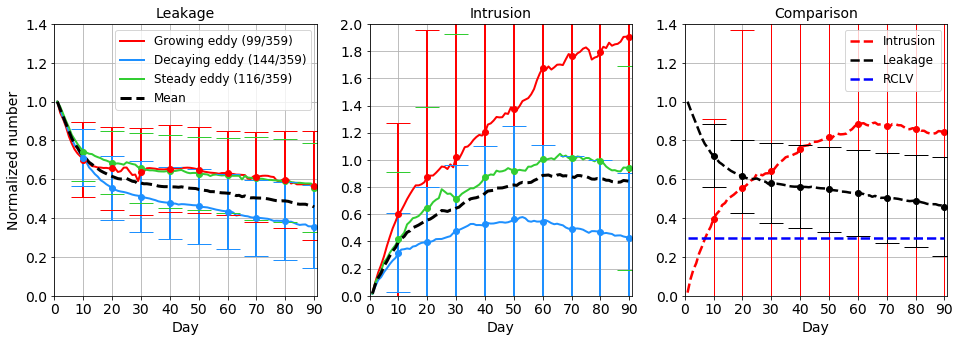

In [17]:
rclv_num = flux1_new[:, 1]
rclv_num = np.nanmean(rclv_num)
eddy_anum = np.nanmean(flux1[1:, 3])

fig = plt.figure(figsize=(16, 5))

plt.subplot(131)
#flux1_mean = np.mean(flux1_new[:,3:],0)
tt = np.arange(90) + 1

hl1 = plt.plot(tt, flux1_grow_mean.T, 'red',
               linewidth=2, label='Growing eddy (99/359)')
hl2 = plt.plot(tt, flux1_decay_mean.T, 'dodgerblue',
               linewidth=2, label='Decaying eddy (144/359)')
hl3 = plt.plot(tt, flux1_stable_mean.T, 'limegreen',
               linewidth=2, label='Steady eddy (116/359)')
hl4 = plt.plot(tt, flux1_mean, 'k--', linewidth=3, label='Mean')

plt.errorbar(flux1_stable_err[0, :], flux1_stable_err[1, :],
             flux1_stable_err[2, :], fmt='o', color='limegreen', linewidth=2, capsize=12)

plt.errorbar(flux1_grow_err[0, :], flux1_grow_err[1, :],
             yerr=flux1_grow_err[2, :], fmt='o', color='red', linewidth=2, capsize=12)

plt.errorbar(flux1_decay_err[0, :], flux1_decay_err[1, :],
             flux1_decay_err[2, :], fmt='o', color='dodgerblue', linewidth=2, capsize=12)


plt.legend(loc=1)
plt.grid()
plt.xticks(ticks=np.arange(0, 91, 10))
plt.xlim(0, 91)
plt.ylim(0, 1.4)
plt.xlabel('Day')
plt.ylabel('Normalized number')
plt.title('Leakage')


plt.subplot(132)
tt = np.arange(90) + 1
plt.plot(tt, flux2_grow_mean.T, 'r', linewidth=2)
plt.plot(tt, flux2_decay_mean.T, 'dodgerblue', linewidth=2)
plt.plot(tt, flux2_stable_mean.T, 'limegreen', linewidth=2)

plt.plot(tt, flux2_mean, 'k--', linewidth=3)

plt.errorbar(flux2_stable_err[0, :], flux2_stable_err[1, :],
             flux2_stable_err[2, :], fmt='o', color='limegreen', linewidth=2, capsize=12)

plt.errorbar(flux2_grow_err[0, :], flux2_grow_err[1, :],
             yerr=flux2_grow_err[2, :], fmt='o', color='red', linewidth=2, capsize=12)

plt.errorbar(flux2_decay_err[0, :], flux2_decay_err[1, :],
             flux2_decay_err[2, :], fmt='o', color='dodgerblue', linewidth=2, capsize=12)
#plt.plot([1, 90], [rclv_num/eddy_anum, rclv_num/eddy_anum], 'lime', linewidth=2, linestyle='--')

plt.grid()
plt.xticks(ticks=np.arange(0, 91, 10))
plt.xlim(0, 91)
plt.ylim(0, 2.0)
plt.yticks(ticks=np.arange(0, 2.1, 0.2))
plt.xlabel('Day')
plt.title('Intrusion')

plt.subplot(133)

hl2 = plt.plot(tt, flux2_mean, color='r', linestyle='--',
               linewidth=2.5, label='Intrusion')

hl1 = plt.plot(tt, flux1_mean,
               'k', linestyle='--', linewidth=2.5, label='Leakage')


hl3 = plt.plot([1, 90], [rclv_num/eddy_anum, rclv_num/eddy_anum],
               'b', linewidth=2.5, linestyle='--', label='RCLV')

plt.errorbar(flux2_mean_err[0, :], flux2_mean_err[1, :],
             flux2_mean_err[2, :], fmt='o', color='r', linewidth=1, capsize=12)

plt.errorbar(flux1_mean_err[0, :], flux1_mean_err[1, :],
             yerr=flux1_mean_err[2, :], fmt='o', color='k', linewidth=1, capsize=12)
plt.legend(loc=1)
plt.grid()
plt.xlim(0, 91)
plt.xlabel('Day')
plt.xticks(ticks=np.arange(0, 91, 10))
plt.ylim(0, 1.4)
plt.title('Comparison')

plt.savefig('Figure_09.png', dpi=300, bbox_inches='tight')

In [18]:
print(flux1_new.shape[0])
print(len(id1[0]))
print(len(id2[0]))
print(len(id3[0]))


359
99
144
116


- The error bar is one standard deviation.

551/578
378/755
481/640
99/99
128/144
112/116


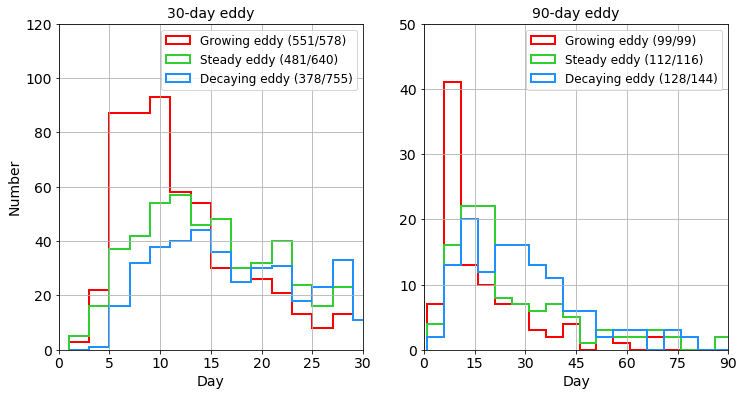

In [20]:
fig = plt.figure(figsize=(12, 6))

plt.subplot(121)

data = np.load('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/eddy_sla_over.npz')
eddy_sla1 = data['arr_0'][1:]
eddy_sla2 = data['arr_1'][1:]
eddy_slam = data['arr_2'][1:]

sla_norm = (eddy_sla2 - eddy_sla1) / eddy_slam

flux1 = np.load(
    '/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/flux1.npy')
flux2 = np.load(
    '/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/flux2.npy')

flux1_new = deepcopy(flux1[1:, :])
flux2_new = deepcopy(flux2[1:, :])

eddy_anum = np.mean(flux1[1:, 3])
for i in np.arange(flux1_new.shape[0]):
    flux1_new[i, 3:] = flux1_new[i, 3:] / eddy_anum
    flux2_new[i, 3:] = flux2_new[i, 3:] / eddy_anum

id1 = np.where(sla_norm >= 0.25)[0]
id2 = np.where(sla_norm <= -0.25)[0]
id3 = np.where((sla_norm > -0.25) & (sla_norm < 0.25))[0]

cday = np.zeros(flux1_new.shape[0])
for i in np.arange(flux1_new.shape[0]):
    tmp1 = flux1_new[i, 3:]
    tmp2 = flux2_new[i, 3:]

    jcondition = np.where(tmp2 > tmp1)
    if len(jcondition[0]) > 1:
        cday[i] = jcondition[0][0] + 1
    else:
        cday[i] = 35


num1 = np.sum(cday[id1] < 30)
num2 = np.sum(cday[id2] < 30)
num3 = np.sum(cday[id3] < 30)

hl1 = plt.hist(cday[id1], bins=np.arange(1, 33, 2).tolist(
), histtype='step', linewidth=2, color='r', label='Growing eddy (551/578)')

hl3 = plt.hist(cday[id3], bins=np.arange(1, 33, 2).tolist(
), histtype='step', linewidth=2, color='limegreen', label='Steady eddy (481/640)')

hl2 = plt.hist(cday[id2], bins=np.arange(1, 33, 2).tolist(
), histtype='step', linewidth=2, color='dodgerblue', label='Decaying eddy (378/755)')

plt.grid()
plt.xlim(0, 30)
plt.ylim(0, 120)
plt.title('30-day eddy')

plt.xlabel('Day')
plt.ylabel('Number')
plt.legend(loc=1)
#plt.savefig('./Figs/Figure_54.pdf', dpi=200, bbox_inches='tight')

print(str(num1) + '/' + str(id1.shape[0]))
print(str(num2) + '/' + str(id2.shape[0]))
print(str(num3) + '/' + str(id3.shape[0]))

plt.subplot(122)

data = np.load('/home/tls2913/scripts/RCLV/statistics_2d/rclv_90_0.1/eddy_sla_over_90.npz')
eddy_sla1 = data['arr_0'][1:]
eddy_sla2 = data['arr_1'][1:]
eddy_slam = data['arr_2'][1:]

sla_norm = (eddy_sla2 - eddy_sla1) / eddy_slam

flux1 = np.load(
    '/home/tls2913/scripts/RCLV/statistics_2d/rclv_90_0.1/flux1.npy')
flux2 = np.load(
    '/home/tls2913/scripts/RCLV/statistics_2d/rclv_90_0.1/flux2.npy')

flux1_new = deepcopy(flux1[1:, :])
flux2_new = deepcopy(flux2[1:, :])

eddy_anum = np.mean(flux1[1:, 3])
for i in np.arange(flux1_new.shape[0]):
    flux1_new[i, 3:] = flux1_new[i, 3:] / eddy_anum
    flux2_new[i, 3:] = flux2_new[i, 3:] / eddy_anum

id1 = np.where(sla_norm >= 0.25)[0]
id2 = np.where(sla_norm <= -0.25)[0]
id3 = np.where((sla_norm > -0.25) & (sla_norm < 0.25))[0]

cday = np.zeros(flux1_new.shape[0])
for i in np.arange(flux1_new.shape[0]):
    tmp1 = flux1_new[i, 3:]
    tmp2 = flux2_new[i, 3:]

    jcondition = np.where(tmp2 > tmp1)
    if len(jcondition[0]) > 1:
        cday[i] = jcondition[0][0] + 1
    else:
        cday[i] = 95

num1 = np.sum(cday[id1] < 90)
num2 = np.sum(cday[id2] < 90)
num3 = np.sum(cday[id3] < 90)

hl1 = plt.hist(cday[id1], bins=np.arange(1, 93, 5).tolist(
), histtype='step', linewidth=2, color='r', label='Growing eddy (99/99)')

hl3 = plt.hist(cday[id3], bins=np.arange(1, 93, 5).tolist(
), histtype='step', linewidth=2, color='limegreen', label='Steady eddy (112/116)')

hl2 = plt.hist(cday[id2], bins=np.arange(1, 93, 5).tolist(
), histtype='step', linewidth=2, color='dodgerblue', label='Decaying eddy (128/144)')

plt.grid()
plt.xlim(0, 90)
plt.xticks(ticks=np.arange(0, 91, 15))
plt.ylim(0, 50)

plt.xlabel('Day')
plt.title('90-day eddy')
# plt.ylabel('Percent')
plt.legend(loc=1)

print(str(num1) + '/' + str(id1.shape[0]))
print(str(num2) + '/' + str(id2.shape[0]))
print(str(num3) + '/' + str(id3.shape[0]))

plt.savefig('Figure_10.png', dpi=300, bbox_inches='tight')